<a href="https://colab.research.google.com/github/ngtaylor/EE461P-Final-Project/blob/main/EE461P_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install catboost
!pip install binarytree==6.2.0
!pip install bracketeer==0.2.0
!pip install setuptools_scm==6.0.1
!pip install toml

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
--2022-05-02 23:02:06--  https://raw.githubusercontent.com/armstrys/NCAA_BracketBuilder/master/kaggle_simulator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9064 (8.9K) [text/plain]
Saving to: ‘kaggle_simulator.py.1’

kaggle_simulator.py 100%[===================>]   8.85K  --.-KB/s    in 0s      

2022-05-02 23:02:06 (91.6 MB/s) - ‘kaggle_simulator.py.1’ saved [9064/9064]



In [43]:
#imports
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from bracketeer import build_bracket
from IPython.display import display, Image

In [44]:
#Import dataset
!wget https://github.com/ngtaylor/EE461P-Final-Project/blob/main/data/MDataFiles_Stage2.zip?raw=true

--2022-05-02 23:04:04--  https://github.com/ngtaylor/EE461P-Final-Project/blob/main/data/MDataFiles_Stage2.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ngtaylor/EE461P-Final-Project/raw/main/data/MDataFiles_Stage2.zip [following]
--2022-05-02 23:04:04--  https://github.com/ngtaylor/EE461P-Final-Project/raw/main/data/MDataFiles_Stage2.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ngtaylor/EE461P-Final-Project/main/data/MDataFiles_Stage2.zip [following]
--2022-05-02 23:04:04--  https://raw.githubusercontent.com/ngtaylor/EE461P-Final-Project/main/data/MDataFiles_Stage2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

In [45]:
#Extract data to '/inputs'
import zipfile
with zipfile.ZipFile('MDataFiles_Stage2.zip?raw=true', 'r') as zip_ref:
    zip_ref.extractall('inputs')

In [46]:
#Load data
venue = pd.read_csv('inputs/MDataFiles_Stage2/MGameCities.csv')
slot = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySlots.csv')
city = pd.read_csv('inputs/MDataFiles_Stage2/Cities.csv')
team = pd.read_csv('inputs/MDataFiles_Stage2/MTeams.csv')
season = pd.read_csv('inputs/MDataFiles_Stage2/MSeasons.csv')
seed = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySeeds.csv')
round_slots = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySeedRoundSlots.csv')
slots = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneySlots.csv')
ncaa1 = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneyDetailedResults.csv')
ncaa2 = pd.read_csv('inputs/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
ncaa2['Comp'] = 'ncaa'
reg1 = pd.read_csv('inputs/MDataFiles_Stage2/MRegularSeasonDetailedResults.csv')
reg2 = pd.read_csv('inputs/MDataFiles_Stage2/MRegularSeasonCompactResults.csv')
ordinals = pd.read_csv('inputs/MDataFiles_Stage2/MMasseyOrdinals_thruDay128.csv')
conf1 = pd.read_csv('inputs/MDataFiles_Stage2/Conferences.csv')
conf2 = pd.read_csv('inputs/MDataFiles_Stage2/MTeamConferences.csv')
ss = pd.read_csv('inputs/MDataFiles_Stage2/MSampleSubmissionStage2.csv')

In [47]:
#Seed is data set for every MM from 1985-2022 Giving division and rank within
seed['region'] = seed.Seed.str[0]
seed['position'] = seed.Seed.str[1:3].astype('int')
seed.head()

,Season,Seed,TeamID,region,position
0,1985,W01,1207,W,1
1,1985,W02,1210,W,2
2,1985,W03,1228,W,3
3,1985,W04,1260,W,4
4,1985,W05,1374,W,5


In [48]:
#One hot encode region
oneHot = pd.get_dummies(seed.region, prefix='region')
seed = seed.join(oneHot)
seed.head()

,Season,Seed,TeamID,region,position,region_W,region_X,region_Y,region_Z
0,1985,W01,1207,W,1,1,0,0,0
1,1985,W02,1210,W,2,1,0,0,0
2,1985,W03,1228,W,3,1,0,0,0
3,1985,W04,1260,W,4,1,0,0,0
4,1985,W05,1374,W,5,1,0,0,0


In [49]:
#WTeam is a data set with 372 unique teams about their D1 start year and end year
WTeam = team.copy()
WTeam = WTeam.rename({'TeamID':'WTeamID'},axis=1)
WTeam = WTeam.rename({'TeamName':'WTeam'},axis=1)

In [50]:
#WTeam is a data set with 372 unique teams about their D1 start year and end year
LTeam = team.copy()
LTeam = LTeam.rename({'TeamID':'LTeamID'},axis=1)
LTeam = LTeam.rename({'TeamName':'LTeam'},axis=1)

In [51]:
#This makes a new data frame with Season and team IDs
new = pd.DataFrame()
new['Season'] = (ss['ID'].str[:4]).astype('int')
new['Comp'] = 'ncaa'
new['MinTeamID'] = (ss['ID'].str[5:9]).astype('int')
new['MaxTeamID'] = (ss['ID'].str[10:14]).astype('int')

In [52]:
for dfr in [seed,season, ncaa1, ncaa2, reg1, reg2]:
    dfr['Season'] = dfr['Season']+1
    dfr['Season'][dfr['Season']>2020]=dfr['Season']-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
reg2['Comp'] = 'reg'
reg2 = reg2[ncaa2.columns]

In [54]:
MinTeam = team.copy()
MinTeam = MinTeam.rename({'TeamID':'MinTeamID'},axis=1)
MinTeam = MinTeam.rename({'TeamName':'MinTeam'},axis=1)

In [55]:
MaxTeam = team.copy()
MaxTeam = MaxTeam.rename({'TeamID':'MaxTeamID'},axis=1)
MaxTeam = MaxTeam.rename({'TeamName':'MaxTeam'},axis=1)

In [56]:
#Set Max and Min team based on which team had the higher ID value
df = ncaa2
df = pd.merge(df,WTeam,on='WTeamID',how='left')
df = pd.merge(df,LTeam,on='LTeamID',how='left')
df['Handicap'] = df['WScore'] - df['LScore']
df['MinTeamID'] = df[['WTeamID','LTeamID']].min(axis=1)
df['MaxTeamID'] = df[['WTeamID','LTeamID']].max(axis=1)
df = df.append(new)

df['ID'] = df['Season'].astype(str) + '_' + df['MinTeamID'].astype(str) + '_' + df['MaxTeamID'].astype(str)
df['target'] = (df['WTeamID']<df['LTeamID']).astype('int')
df = pd.merge(df,MinTeam,on='MinTeamID',how='left')
df = pd.merge(df,MaxTeam,on='MaxTeamID',how='left')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'LastD1Season_x', 'FirstD1Season_x'} in the result is deprecated and will raise a MergeError in a future version.
  del sys.path[0]


In [57]:
#This just combines the year and ID into one string
df['MinTeamIDY'] = df['Season'].astype(str) + '_' + df['MinTeamID'].astype(str)
df['MaxTeamIDY'] = df['Season'].astype(str) + '_' + df['MaxTeamID'].astype(str)

seed['MaxTeamIDY'] = seed['Season'].astype(str) + '_' + seed['TeamID'].astype(str)
seed['MinTeamIDY'] = seed['Season'].astype(str) + '_' + seed['TeamID'].astype(str)

In [58]:
#Add teams aggregate mean ordinal rank and difference in rank between two teams
df_rank = ordinals.groupby(["TeamID"])["OrdinalRank"].agg(np.mean).reset_index()
ranks_Max = df_rank.copy()
ranks_Min = df_rank.copy()
ranks_Max.columns = ['MaxTeamID','Max_rank_mean']
ranks_Min.columns = ['MinTeamID','Min_rank_mean']
df = pd.merge(df,ranks_Max,on = ["MaxTeamID"],how = "left")
df = pd.merge(df,ranks_Min,on = ["MinTeamID"],how = "left")
df["rankdiff"] = df["Max_rank_mean"] - df["Min_rank_mean"]
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Comp,WTeam,...,FirstD1Season_x,LastD1Season_x,MaxTeam,FirstD1Season_y,LastD1Season_y,MinTeamIDY,MaxTeamIDY,Max_rank_mean,Min_rank_mean,rankdiff
0,1986,136.0,1116.0,63.0,1234.0,54.0,N,0.0,ncaa,Arkansas,...,1985,2022,Iowa,1985,2022,1986_1116,1986_1234,64.197509,61.044654,3.152856
1,1986,136.0,1120.0,59.0,1345.0,58.0,N,0.0,ncaa,Auburn,...,1985,2022,Purdue,1985,2022,1986_1120,1986_1345,41.506060,96.834078,-55.328018
2,1986,136.0,1207.0,68.0,1250.0,43.0,N,0.0,ncaa,Georgetown,...,1985,2022,Lehigh,1985,2022,1986_1207,1986_1250,204.574156,58.107864,146.466292
3,1986,136.0,1229.0,58.0,1425.0,55.0,N,0.0,ncaa,Illinois St,...,1985,2022,USC,1985,2022,1986_1229,1986_1425,82.043060,140.447530,-58.404470
4,1986,136.0,1242.0,49.0,1325.0,38.0,N,0.0,ncaa,Kansas,...,1985,2022,Ohio,1985,2022,1986_1242,1986_1325,131.882451,9.807722,122.074729


In [59]:
df = pd.merge(df,seed[['MinTeamIDY','position', 'region_W', 'region_X', 'region_Y', 'region_Z']],on='MinTeamIDY',how='left')
df = pd.merge(df,seed[['MaxTeamIDY','position', 'region_W', 'region_X', 'region_Y', 'region_Z']],on='MaxTeamIDY',how='left')
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Comp,WTeam,...,position_x,region_W_x,region_X_x,region_Y_x,region_Z_x,position_y,region_W_y,region_X_y,region_Y_y,region_Z_y
0,1986,136.0,1116.0,63.0,1234.0,54.0,N,0.0,ncaa,Arkansas,...,9,0,1,0,0,8,0,1,0,0
1,1986,136.0,1120.0,59.0,1345.0,58.0,N,0.0,ncaa,Auburn,...,11,0,0,0,1,6,0,0,0,1
2,1986,136.0,1207.0,68.0,1250.0,43.0,N,0.0,ncaa,Georgetown,...,1,1,0,0,0,16,1,0,0,0
3,1986,136.0,1229.0,58.0,1425.0,55.0,N,0.0,ncaa,Illinois St,...,9,0,0,1,0,8,0,0,1,0
4,1986,136.0,1242.0,49.0,1325.0,38.0,N,0.0,ncaa,Kansas,...,3,0,0,0,1,14,0,0,0,1


In [60]:
pred_yr = 2022
history = df[df.Season<pred_yr]
history1 = history[['Season','MinTeamID','MaxTeamID','target']].rename({'MinTeamID':'TeamID','MaxTeamID':'OpponentID'},axis=1)
history2 = history[['Season','MaxTeamID','MinTeamID','target']].rename({'MaxTeamID':'TeamID','MinTeamID':'OpponentID'},axis=1)
history2.target = 1 - history2.target 
history = history1.append(history2)

In [61]:
#Create stats per season
yr_stats = history.copy()
yr_stats['win_stats'] = yr_stats.groupby(['TeamID','Season'])['target'].transform('mean')
yr_stats['played'] = yr_stats.groupby(['TeamID','Season'])['target'].transform('count')
yr_stats.drop(['OpponentID','target'],axis=1,inplace=True)
yr_stats = yr_stats.sort_values(['Season','win_stats'])
yr_stats = yr_stats.drop_duplicates(['TeamID','Season'])

yr_stats.Season = yr_stats.Season + 1
yr_stats['MaxTeamIDY'] = yr_stats['Season'].astype(str) + '_' + yr_stats['TeamID'].astype(str)
yr_stats['MinTeamIDY'] = yr_stats['Season'].astype(str) + '_' + yr_stats['TeamID'].astype(str)

yr_stats.describe()

,Season,TeamID,win_stats,played
count,2353.000000,2353.000000,2353.000000,2353.000000
mean,2004.726307,1291.514662,0.311482,1.969401
std,10.422123,103.296346,0.321486,1.279050
min,1987.000000,1101.000000,0.000000,1.000000
25%,1996.000000,1208.000000,0.000000,1.000000
50%,2005.000000,1287.000000,0.500000,2.000000
75%,2014.000000,1387.000000,0.500000,2.000000
max,2022.000000,1463.000000,1.000000,6.000000


In [62]:
# Add year stats for year of prediction to our dataframe
df = pd.merge(df,yr_stats[['MinTeamIDY','win_stats','played']],on='MinTeamIDY',how='left')
df = pd.merge(df,yr_stats[['MaxTeamIDY','win_stats','played']],on='MaxTeamIDY',how='left')

df.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,FirstD1Season_x,LastD1Season_x,FirstD1Season_y,...,region_Z_x,position_y,region_W_y,region_X_y,region_Y_y,region_Z_y,win_stats_x,played_x,win_stats_y,played_y
count,4595.000000,2317.000000,2317.000000,2317.000000,2317.000000,2317.000000,2317.000000,2317.000000,2317.0,2317.000000,...,4595.000000,4595.000000,4595.000000,4595.00000,4595.000000,4595.000000,2371.000000,2371.000000,2445.000000,2445.000000
mean,2012.787378,139.167890,1286.536901,76.891239,1292.018127,65.168321,0.069055,1985.155373,2022.0,1985.631420,...,0.252231,8.013058,0.278564,0.22111,0.253319,0.247008,0.476093,2.693378,0.416639,2.379141
std,11.756983,4.217412,100.988726,11.836804,103.292844,11.064350,0.282592,1.563573,0.0,3.129421,...,0.434340,4.671844,0.448341,0.41504,0.434959,0.431318,0.324098,1.590861,0.316389,1.449016
min,1986.000000,134.000000,1101.000000,43.000000,1101.000000,29.000000,0.000000,1985.000000,2022.0,1985.000000,...,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2004.000000,136.000000,1210.000000,69.000000,1209.000000,58.000000,0.000000,1985.000000,2022.0,1985.000000,...,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2021.000000,137.000000,1276.000000,76.000000,1290.000000,65.000000,0.000000,1985.000000,2022.0,1985.000000,...,0.000000,8.000000,0.000000,0.00000,0.000000,0.000000,0.500000,2.000000,0.500000,2.000000
75%,2022.000000,139.000000,1385.000000,84.000000,1387.000000,72.000000,0.000000,1985.000000,2022.0,1985.000000,...,1.000000,12.000000,1.000000,0.00000,1.000000,0.000000,0.750000,4.000000,0.666667,3.000000
max,2022.000000,154.000000,1463.000000,149.000000,1463.000000,115.000000,3.000000,2014.000000,2022.0,2014.000000,...,1.000000,16.000000,1.000000,1.00000,1.000000,1.000000,1.000000,6.000000,1.000000,6.000000


In [63]:
#Replace missing values: replace missing win stat with 0.5 and missing played with 2
df['win_stats_x'] = df['win_stats_x'].fillna(0.5)
df['win_stats_y'] = df['win_stats_y'].fillna(0.5)

df['played_x'] = df['played_x'].fillna(2)
df['played_y'] = df['played_y'].fillna(2)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Comp,WTeam,...,region_Z_x,position_y,region_W_y,region_X_y,region_Y_y,region_Z_y,win_stats_x,played_x,win_stats_y,played_y
0,1986,136.0,1116.0,63.0,1234.0,54.0,N,0.0,ncaa,Arkansas,...,0,8,0,1,0,0,0.5,2.0,0.5,2.0
1,1986,136.0,1120.0,59.0,1345.0,58.0,N,0.0,ncaa,Auburn,...,1,6,0,0,0,1,0.5,2.0,0.5,2.0
2,1986,136.0,1207.0,68.0,1250.0,43.0,N,0.0,ncaa,Georgetown,...,0,16,1,0,0,0,0.5,2.0,0.5,2.0
3,1986,136.0,1229.0,58.0,1425.0,55.0,N,0.0,ncaa,Illinois St,...,0,8,0,0,1,0,0.5,2.0,0.5,2.0
4,1986,136.0,1242.0,49.0,1325.0,38.0,N,0.0,ncaa,Kansas,...,1,14,0,0,0,1,0.5,2.0,0.5,2.0


In [64]:
#Categorical columns and numerical columns only using features that matter
cat_cols = ['MinTeamID','MaxTeamID','region_W_x','region_X_x','region_Y_x','region_Z_x','region_W_y','region_X_y','region_Y_y','region_Z_y',] 
num_cols = [
    'position_x','position_y',
    'win_stats_x','played_x','win_stats_y','played_y',
    'Max_rank_mean', 'Min_rank_mean', 'rankdiff'
]
cols = num_cols+cat_cols

In [ ]:
#Create training data dataframe for the model
tdf = df[df.Season==pred_yr]
tdf = tdf[tdf['Comp']=='ncaa']
reg_pred_yr = df[(df.Season==pred_yr)&(df.Comp=='reg')]

train = df[df.Season<pred_yr].append(reg_pred_yr)

train[cols]

,position_x,position_y,win_stats_x,played_x,win_stats_y,played_y,Max_rank_mean,Min_rank_mean,rankdiff,MinTeamID,MaxTeamID,region_W_x,region_X_x,region_Y_x,region_Z_x,region_W_y,region_X_y,region_Y_y,region_Z_y
0,9,8,0.500000,2.0,0.500000,2.0,64.197509,61.044654,3.152856,1116,1234,0,1,0,0,0,1,0,0
1,11,6,0.500000,2.0,0.500000,2.0,41.506060,96.834078,-55.328018,1120,1345,0,0,0,1,0,0,0,1
2,1,16,0.500000,2.0,0.500000,2.0,204.574156,58.107864,146.466292,1207,1250,1,0,0,0,1,0,0,0
3,9,8,0.500000,2.0,0.500000,2.0,82.043060,140.447530,-58.404470,1229,1425,0,0,1,0,0,0,1,0
4,3,14,0.500000,2.0,0.500000,2.0,131.882451,9.807722,122.074729,1242,1325,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312,1,6,0.750000,4.0,0.500000,2.0,82.043060,17.652159,64.390901,1211,1425,0,1,0,0,0,1,0,0
2313,1,11,0.666667,3.0,0.500000,2.0,56.103116,45.146156,10.956960,1276,1417,1,0,0,0,1,0,0,0
2314,1,2,0.500000,2.0,0.666667,3.0,98.041546,49.867535,48.174011,1124,1222,0,0,0,1,0,0,1,0
2315,1,11,0.750000,4.0,0.500000,2.0,56.103116,17.652159,38.450958,1211,1417,0,1,0,0,1,0,0,0


In [65]:
#Train MLP Classifier model
mlp_class = MLPClassifier()
mlp_class.fit(train[cols], train.target, )

tdf['Pred'] = mlp_class.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
mlp_output = ss.copy()
mlp_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
mlp_output.to_csv('mlp_pred.csv',index=False)
mlp_output

,ID,Pred
0,2022_1103_1104,0.231666
1,2022_1103_1112,0.097368
2,2022_1103_1116,0.188000
3,2022_1103_1120,0.152130
4,2022_1103_1124,0.143388
...,...,...
2273,2022_1458_1461,0.817106
2274,2022_1458_1463,0.864642
2275,2022_1460_1461,0.401168
2276,2022_1460_1463,0.401345


In [66]:
#Cat Boost classifier model (deals with missing values internally)
cat = CatBoostClassifier(n_estimators=50,silent=True,objective='Logloss',
                          cat_features=cat_cols)
cat.fit(train[cols],train.target)
tdf['Pred'] = cat.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
cat_output = ss.copy()
cat_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
cat_output.to_csv('cat_pred.csv',index=False)
cat_output

,ID,Pred
0,2022_1103_1104,0.257703
1,2022_1103_1112,0.102981
2,2022_1103_1116,0.248746
3,2022_1103_1120,0.183877
4,2022_1103_1124,0.142724
...,...,...
2273,2022_1458_1461,0.869554
2274,2022_1458_1463,0.889429
2275,2022_1460_1461,0.260657
2276,2022_1460_1463,0.439650


In [67]:
#Train Logistic Regression model
reg = LogisticRegression(max_iter=1000)
reg.fit(train[cols], train.target)

tdf['Pred'] = reg.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
reg_output = ss.copy()
reg_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
reg_output.to_csv('reg_pred.csv',index=False)
reg_output

,ID,Pred
0,2022_1103_1104,0.241033
1,2022_1103_1112,0.116380
2,2022_1103_1116,0.203342
3,2022_1103_1120,0.189343
4,2022_1103_1124,0.150624
...,...,...
2273,2022_1458_1461,0.830148
2274,2022_1458_1463,0.867747
2275,2022_1460_1461,0.324000
2276,2022_1460_1463,0.391515


In [68]:
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn import model_selection

#Train Random Forest model
rando_forest = ensemble.RandomForestClassifier()
params = {'n_estimators': [50, 75, 100, 125, 150], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}
gs = model_selection.GridSearchCV(rando_forest, params)
gs_fit = gs.fit(train[cols], train.target)
gs_fit.best_params_

rando_forest_optimal = ensemble.RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=50)
rando_forest_optimal_fit = rando_forest_optimal.fit(train[cols], train.target)

tdf['Pred'] = rando_forest_optimal_fit.predict_proba(tdf[cols])[:,1]

#Output is prediction of match outcomes, it shows the percentage chance that the first team beats the second team for a given matchup
rf_output = ss.copy()
rf_output = pd.merge(ss['ID'],tdf[['ID','Pred']],on='ID',how='left')
rf_output.to_csv('rf_pred.csv',index=False)
rf_output

,ID,Pred
0,2022_1103_1104,0.20
1,2022_1103_1112,0.16
2,2022_1103_1116,0.18
3,2022_1103_1120,0.12
4,2022_1103_1124,0.20
...,...,...
2273,2022_1458_1461,0.84
2274,2022_1458_1463,0.92
2275,2022_1460_1461,0.36
2276,2022_1460_1463,0.46


In [ ]:
#Then we would apply these results to the actual tournament results, and use different models to do so
#A bracket structure needs to be simulated using the TourneyRoundSlots, TourneySeeds, and TourneySlots csvs
#The starting seeds for 2022 are given so we just need to manually compare to the actual results once we have made our own bracket



In [69]:
#create bracket
def display_bracket(file_name):
  inp = 'inputs/MDataFiles_Stage2/'

  b = build_bracket(
  outputPath='MNCAA2022.png',
  teamsPath=inp+'MTeams.csv',
  seedsPath=inp+'MNCAATourneySeeds.csv',
  submissionPath=file_name,
  slotsPath=inp+'MNCAATourneySlots.csv',
  year=2022
  )

  display(Image(filename='./MNCAA2022.png'))

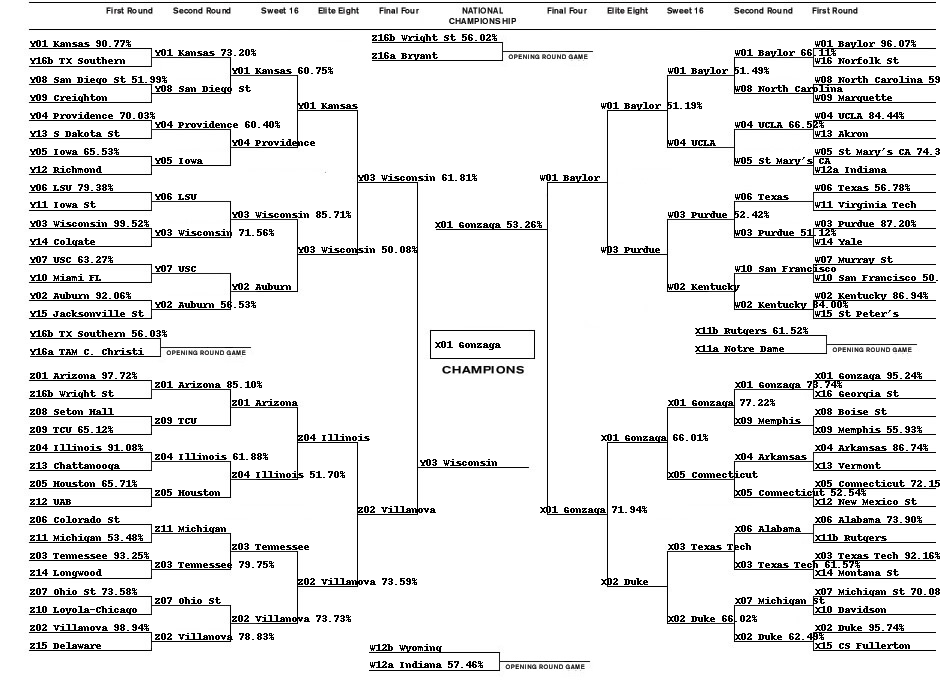

In [70]:
display_bracket('mlp_pred.csv')

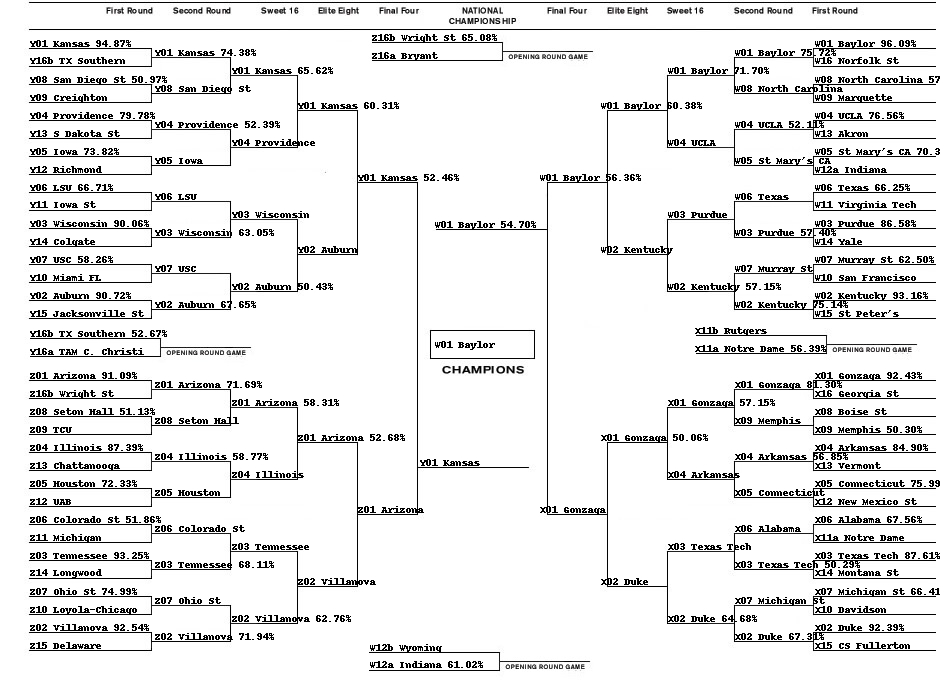

In [71]:
display_bracket('reg_pred.csv')

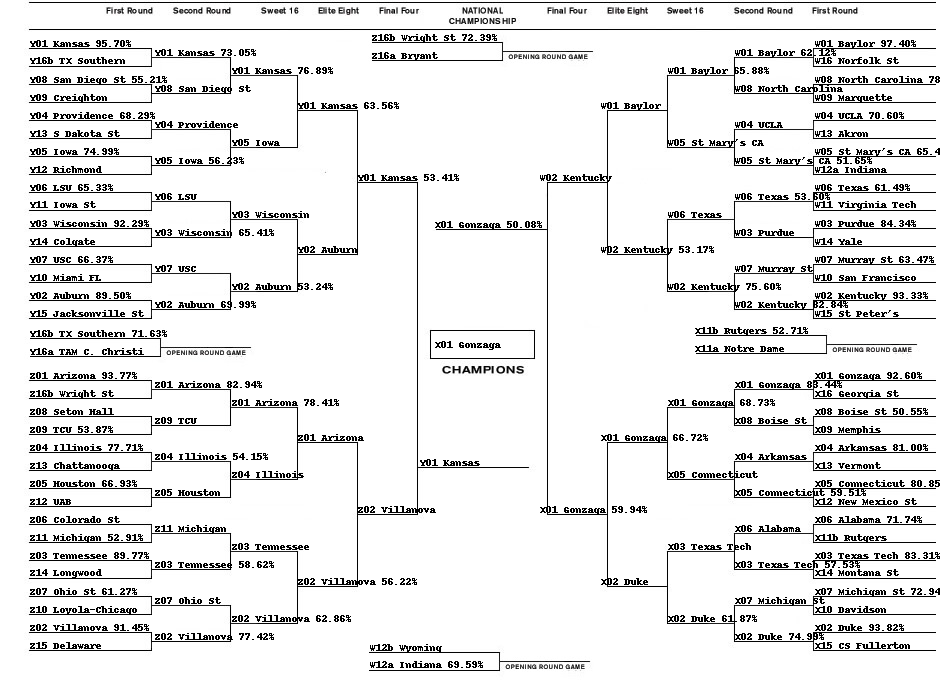

In [72]:
display_bracket('cat_pred.csv')

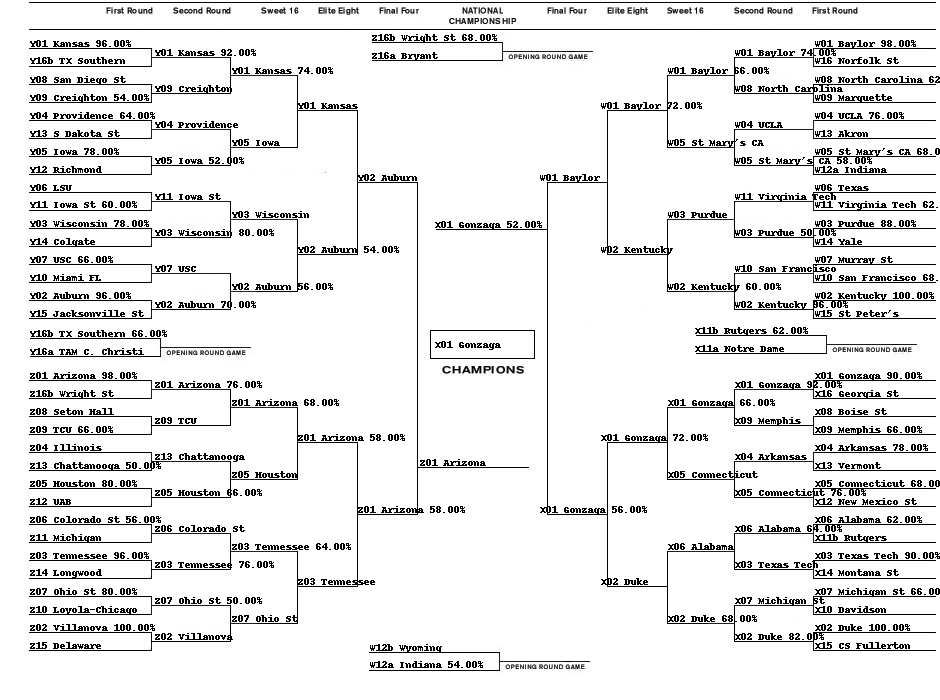

In [73]:
display_bracket('rf_pred.csv')